In [2]:
import urllib.request
import pandas as pd
import numpy as np


In [49]:
# Read data
# gotten from https://www.ucsusa.org/resources/satellite-database
raw_df = pd.read_excel("../data/UCS-Satellite-Database-5-1-2022.xls")
raw_df.head()

,"Name of Satellite, Alternate Names",Current Official Name of Satellite,Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,...,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66
0,1HOPSAT-TD (1st-generation High Optical Perfor...,1HOPSAT-TD,NR,USA,Hera Systems,Commercial,Earth Observation,Infrared Imaging,LEO,Non-Polar Inclined,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aalto-1,Aalto-1,Finland,Finland,Aalto University,Civil,Technology Development,NaN,LEO,Sun-Synchronous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAUSat-4,AAUSat-4,Denmark,Denmark,University of Aalborg,Civil,Earth Observation,Automatic Identification System (AIS),LEO,Sun-Synchronous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"ABS-2 (Koreasat-8, ST-3)",ABS-2,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABS-2A,ABS-2A,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
raw_df.shape

(5467, 67)

In [61]:
df = raw_df.rename({'Name of Satellite, Alternate Names': "Name"}, axis=1)
df = df.rename({'Date of Launch': "launch_date"}, axis=1)

In [69]:
# Handle dates properly
df['launch_date'] = pd.to_datetime(df['launch_date'])
df.index = df.launch_date
df = df[~df.index.isna()]
df = df[df["Class of Orbit"] == "LEO"]
df = df[df["Purpose"] == "Communications"]
df.shape

(3108, 67)

In [70]:
# Make a note that the indexing happends at the end of each week as seen below
test = df[df["Name"].str.lower().str.contains("starlink")]
print(test)
test.groupby([pd.Grouper(key='launch_date', freq='W-MON')])["Name"].count().reset_index()

                      Name Current Official Name of Satellite  \
launch_date                                                     
2019-11-11   Starlink-1007                      Starlink-1007   
2019-11-11   Starlink-1008                      Starlink-1008   
2019-11-11   Starlink-1009                      Starlink-1009   
2019-11-11   Starlink-1010                      Starlink-1010   
2019-11-11   Starlink-1011                      Starlink-1011   
...                    ...                                ...   
2019-05-24    Starlink-68                        Starlink-68    
2019-05-24    Starlink-70                        Starlink-70    
2019-05-24    Starlink-71                        Starlink-71    
2019-05-24    Starlink-73                        Starlink-73    
2019-05-24    Starlink-79                        Starlink-79    

            Country/Org of UN Registry Country of Operator/Owner  \
launch_date                                                        
2019-11-11        

,launch_date,Name
0,2019-05-27,13
1,2019-06-03,0
2,2019-06-10,0
3,2019-06-17,0
4,2019-06-24,0
...,...,...
149,2022-04-04,0
150,2022-04-11,0
151,2022-04-18,0
152,2022-04-25,53


In [71]:
# Get daily/weekly summation of launches
def get_counts(df, regex, negate=False):
    if negate:
        subset = df[~(df["Name"].str.lower().str.contains(regex).values)]
    else:
        subset = df[(df["Name"].str.lower().str.contains(regex).values)]
#     weekly = subset.groupby([pd.Grouper(key='launch_date', freq='W-MON')])["Name"].count().reset_index()
    counts = subset.groupby([pd.Grouper(key='launch_date', freq='D')])["Name"].count().reset_index()
    counts.columns = ["launch_date", "count"]
    counts["cumsum"] = counts["count"].cumsum()
    counts.index = counts.launch_date
    return counts

In [72]:
starlink = get_counts(df, "starlink")
oneweb = get_counts(df, "oneweb")
neither = get_counts(df, "starlink|oneweb", negate=True)
oneweb.head(5)

,launch_date,count,cumsum
launch_date,,,
2019-02-27,2019-02-27,6,6
2019-02-28,2019-02-28,0,6
2019-03-01,2019-03-01,0,6
2019-03-02,2019-03-02,0,6
2019-03-03,2019-03-03,0,6


(17897.0, 19113.0)

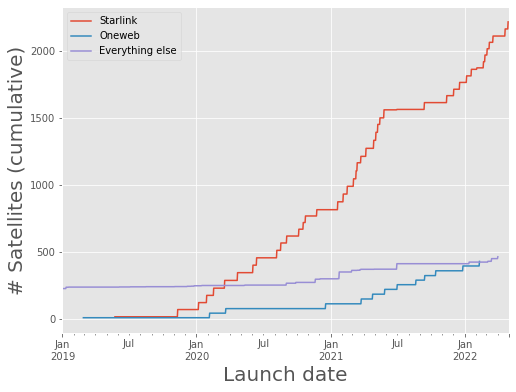

In [73]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
starlink["cumsum"].plot(figsize=(8,6), label="Starlink") 
oneweb["cumsum"].plot(label="Oneweb") 
neither["cumsum"].plot(label="Everything else") 
plt.ylabel("# Satellites (cumulative)", fontsize=20)
plt.xlabel("Launch date", fontsize=20)
plt.legend()
plt.xlim([np.datetime64("2019-01-01"), np.datetime64("2022-05-01")])

In [74]:
death = pd.read_csv("../data/state_centered.csv")
death.head()

,Unnamed: 0,State,flu_like_deaths,detrended,detrended_flu_like,median,median_flu_like,Week.Ending.Date,Total.Deaths,data_set,MMWR.Week,centered,centered_flu_like,non_flu_deaths,detrended_non_flu_like,centered_non_flu_like
0,1,Alabama,38.0,1057.000000,38.0,1067.139241,33.5,2014-01-04,1057,2014-2019,1,-10.139241,4.5,1019.0,1019.000000,-14.639241
1,2,Alabama,37.0,1076.721519,37.0,1081.360759,35.0,2014-01-11,1077,2014-2019,2,-4.639241,2.0,1040.0,1039.721519,-6.639241
2,3,Alabama,34.0,1047.443038,34.0,1034.221519,32.5,2014-01-18,1048,2014-2019,3,13.221519,1.5,1014.0,1013.443038,11.721519
3,4,Alabama,42.0,1021.164557,42.0,1005.544304,23.0,2014-01-25,1022,2014-2019,4,15.620253,19.0,980.0,979.164557,-3.379747
4,5,Alabama,26.0,1039.886076,26.0,1056.265823,23.5,2014-02-01,1041,2014-2019,5,-16.379747,2.5,1015.0,1013.886076,-18.879747


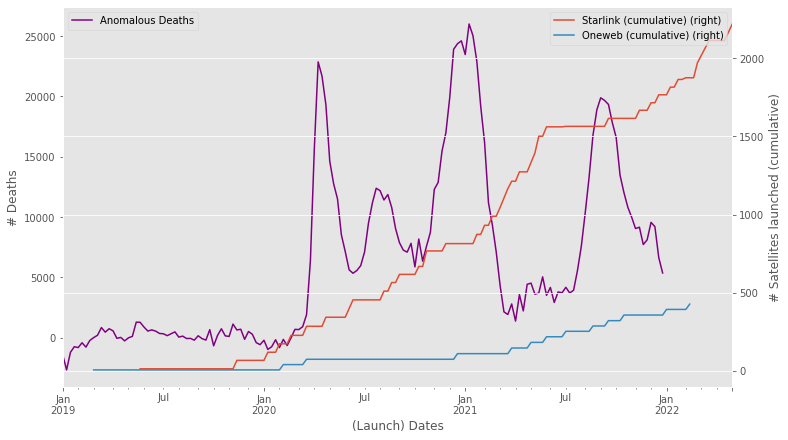

In [75]:
death.index = pd.to_datetime(death["Week.Ending.Date"])
us_death = death[(death.State == "United States") & (death.index.year >= 2019)]

# us_death["Total.Deaths"].plot(label="Deaths")
ax1 = us_death["centered"].plot(figsize=(12,7), label="Anomalous Deaths", color="purple")
# plt.legend(loc="upper left")
ax1.set_ylabel("# Deaths")

# ax2 = ax1.twinx()
# ax2.spines['right'].set_position(('axes', 1.0))
starlink["cumsum"].plot(ax=ax1, label="Starlink (cumulative)", secondary_y=True) 
oneweb["cumsum"].plot(ax=ax1, label="Oneweb (cumulative)", secondary_y=True) 
ax1.right_ax.set_ylabel("# Satellites launched (cumulative)")
first_legend = plt.legend(handles=[ax1.lines[0]], loc='upper left')
ax1.right_ax.set_xlabel("(Launch) Dates")
plt.gca().add_artist(first_legend)
plt.legend(handles=ax1.right_ax.lines, loc='upper right')
ax1.set_xlabel("(Launch) Dates")
plt.savefig("../figures/satellite_death.pdf")